In [ ]:
!pip3 install rpy2 torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [3]:
%matplotlib inline

In [4]:
%load_ext rpy2.ipython

In [ ]:
%%R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.16")

In [ ]:
%%R
BiocManager::install("splatter")

In [7]:
%%R
# Load package
suppressPackageStartupMessages({
  library(splatter)
  library(scater)
})

## 1)Pre-processing
### 1.1) Simulate 5000 samples with 2000 genes from two cell types and load the samples in Torch tensors and provide a DataLoader.

In [8]:
%%R
sim <- splatSimulate(method="groups", nGenes = 2000, batchCells = 5000 , mean.rate = 0.6, dropout.mid = c(6, 3), dropout.shape=c(-1,-1), dropout.type="group", group.prob = c(0.9, 0.1), verbose=FALSE)

In [9]:
%%R
write.table(as.array(counts(sim)), sep='\t', 'data.tsv')
write.table(colData(sim), sep='\t', 'labels.tsv')

In [10]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

batch_size = 32
data = pd.read_csv('data.tsv', sep='\t').transpose().to_numpy()
labels = pd.read_csv('labels.tsv', sep='\t')["Group"].to_numpy()

In [11]:
data = preprocessing.normalize(data)
labels = preprocessing.LabelBinarizer().fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.long)
X_test = torch.from_numpy(X_test).to(torch.float32)
y_test = torch.from_numpy(y_test).to(torch.long)

In [12]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train) 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### 1.2) Normalized samples using z-score normalization and plot them beside raw samples

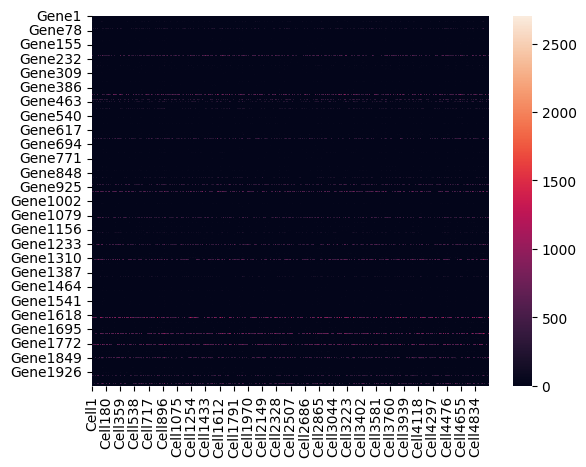

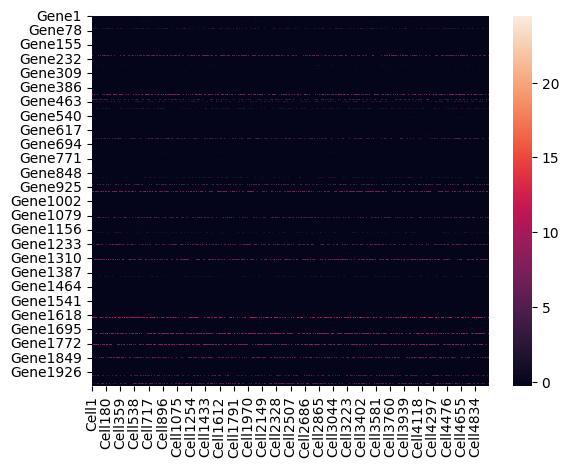

In [13]:
from scipy.stats import zscore
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
df=pd.read_csv('data.tsv', sep='\t')
df2=zscore(df)

ax = sns.heatmap(df)
plt.show()

ax2 = sns.heatmap(df2)
plt.show()

## 2) Train a MLP on the data to classify rna samples into one of the two cell types.
### 2.1) implement following MLP model in sequential fashion.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2000, 500)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(500, 500)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(500, 2)

    def forward(self, x):
        x = x.view(-1, 2000)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.softmax(self.fc3(x), dim=1)

### 2.2) Instantiate (and name) the MLP model as `model`, Stochastic Gradient Descent optimizer as `optimizer` and Cross entropy loss as `criterion`. 


In [15]:
import torch
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
criterion = nn.CrossEntropyLoss()

### 2.3) Fix the bug/s of the train method

In [16]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    for _ in range(epoch):
        # Loop over each batch from the training set
        for batch_idx, (data, target) in enumerate(train_loader):
            output = model(data)
            loss = criterion(output, target.view(-1))
            loss.backward()
            optimizer.step()
train(10)

## 3) Evaluation
### 3.1) Change the previous codes to calculate test and train loss.

In [17]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    i = 1
    for _ in range(epoch):
        # Loop over each batch from the training set
        for batch_idx, (data, target) in enumerate(train_loader):
            output = model(data)
            loss = criterion(output, target.view(-1))
            if i % log_interval == 0:
                print(f'Train Loss: {loss.item()}')
            i += 1
            loss.backward()
            optimizer.step()
    # Calculate test loss
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target.view(-1)).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss}')

train(50)

Train Loss: 0.34451165795326233
Train Loss: 0.34451165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.43826165795326233
Train Loss: 0.46951165795326233
Train Loss: 0.40701165795326233
Train Loss: 0.40701165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.37576162815093994
Train Loss: 0.40701162815093994
Train Loss: 0.37576165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.37576162815093994
Train Loss: 0.46951165795326233
Train Loss: 0.5320116281509399
Train Loss: 0.46951165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.34451165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.31326165795326233
Train Loss: 0.43826165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.34451165795326233
Train Loss: 0.37576165795326233
Train Loss: 0.43826162815093994
Train Loss: 0.37576165795326233
Test Loss

### 3.2) Change the previous codes to calculate Accuracy, specificity, sensitivity, and AUC for test set.

In [18]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
def test():
    # Set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target.view(-1))
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            y_true.append(target)
            y_pred.append(pred)
    test_loss /= len(test_loader.dataset)
    print("Test loss: ", test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Specificity: ", recall_score(y_true, y_pred, pos_label=0))
    print("Sensitivity: ", recall_score(y_true, y_pred))
    print("AUC: ", roc_auc_score(y_true, y_pred))

test()

Test loss:  tensor(0.0131)

Test set: Average loss: 0.0131, Accuracy: 909/1000 (91%)

Accuracy:  0.909
Specificity:  1.0
Sensitivity:  0.0
AUC:  0.5
